In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import matplotlib as plt
import  statsmodels .api  as  sm 
from  sklearn.linear_model  import  LinearRegression
import  cvxpy  as  cv

In [2]:
start = "2016-01-01"
end = "2020-12-30"

# Tickers of assets
assets = ['DGX', 'MMM', 'ABBV', 'LLY', 'MDT', 'MRK', 'CTLT', 'IQV']
assets.sort()

In [3]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

market_data = yf.download("^GSPC", start = start, end = end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
port_diff = data[assets].pct_change().dropna()
mkt_diff = market_data.pct_change().dropna()

In [5]:
################################################## ####################### 
# Calculating the Betas 
######################## ################################################ 

# Using statsmodels 
x = mkt_diff.values 
x = sm.add_constant(x)

Beta_1  =  [] 
for i in assets:
    y_i =  port_diff[i].values 
    mod =  sm.OLS(y_i, x) 
    res =  mod.fit() 
    Beta_1.append(res.params[1])

Beta_1 = np.matrix(Beta_1)

# Using scikit learn 
y = port_diff.values 
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
reg = LinearRegression().fit(x, y)
Beta_2 = np.matrix(reg.coef_).T

# Combining both betas to show them 
B1 = pd.DataFrame(Beta_1.T, index = assets, columns = ['Beta_1']) 
B2 = pd.DataFrame(Beta_2.T, index = assets, columns = ['Beta_2'])

B1_B2 = pd.concat([B1, B2], axis = 1)


In [6]:
################################################## ####################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
########### ################################################## ###########

Sigma_rm = np.matrix(np.var(mkt_diff, ddof = 1))

x = mkt_diff.values 
x = sm.add_constant(x)

mu_F_1 = []
Sigma_e_1 = []
for i in assets:
    y_i = port_diff[i].values
    mod = sm.OLS(y_i, x)
    res = mod.fit()
    error = np.matrix(y_i) - np.matrix(res.predict(x))
    mu_F_1.append(np.mean(res.predict(x), axis = 0))
    Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))

mu_F_1 = np.matrix(mu_F_1)
Sigma_e_1 = np.diag(Sigma_e_1)
Sigma_F_1 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_1

display(pd.DataFrame(mu_F_1, columns = assets))
display(pd.DataFrame(Sigma_F_1, index = assets, columns = assets))

<ipython-input-6-f7317817409b>:19: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))


ABBV      CTLT       DGX       IQV       LLY       MDT       MMM  \
0  0.000821  0.001415  0.000619  0.000943  0.000791  0.000538  0.000369   

        MRK  
0  0.000566

ABBV      CTLT       DGX       IQV       LLY       MDT       MMM  \
ABBV  0.000337  0.000136  0.000092  0.000139  0.000088  0.000107  0.000107   
CTLT  0.000136  0.000536  0.000126  0.000190  0.000121  0.000147  0.000147   
DGX   0.000092  0.000126  0.000255  0.000128  0.000081  0.000099  0.000099   
IQV   0.000139  0.000190  0.000128  0.000358  0.000123  0.000150  0.000150   
LLY   0.000088  0.000121  0.000081  0.000123  0.000283  0.000095  0.000095   
MDT   0.000107  0.000147  0.000099  0.000150  0.000095  0.000238  0.000116   
MMM   0.000107  0.000147  0.000099  0.000150  0.000095  0.000116  0.000236   
MRK   0.000085  0.000116  0.000078  0.000118  0.000075  0.000091  0.000092   

           MRK  
ABBV  0.000085  
CTLT  0.000116  
DGX   0.000078  
IQV   0.000118  
LLY   0.000075  
MDT   0.000091  
MMM   0.000092  
MRK   0.000194

In [7]:
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
error_2 = y - reg.predict(x)

mu_F_2 = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_e_2 = np.diag(np.var(error_2, ddof = 1, axis = 0))
Sigma_F_2 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_2

#display(pd.DataFrame(mu_F_2, columns = assets))
#display(pd.DataFrame(Sigma_F_2, index = assets, columns = assets))

In [8]:
################################################## ###################### 
# Calculating optimal portfolios with historical estimates 
# and CAPM estimates 
############# ################################################## #########

# Defining the optimization function 
def Max_Sharpe(mu, Sigma):
    w = cv.Variable((mu.shape[1], 1))
    k = cv.Variable(1)
    rf = cv.Parameter(nonneg=True)
    rf.value=0
    #defining the problem, objective function and    
    constraints = [(mu - rf)*w == 1,
                   w >= 1e-10,
                   k >= 1e-10,
                   cv.sum(w) == k]
    prob = cv.Problem(cv.Minimize(cv.quad_form(w, Sigma)), constraints)
    #solving the problem
    prob.solve(solver=cv.ECOS)

    return np.matrix(w.value/k.value)

mu = np.matrix(np.mean(port_diff.values, axis = 0))
Sigma = np.cov(port_diff.values.T)

w1 = Max_Sharpe(mu, Sigma)
w2 = Max_Sharpe(mu_F_2, Sigma_F_2)

W1 = pd.DataFrame(w1, index = assets, columns = ['Historical'])
W2 = pd.DataFrame(w2, index = assets, columns = ['CAPM'])

#display(pd.concat([W1, W2], axis = 1).applymap("{0:.2%}".format))

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\problems\problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CV

In [9]:
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import matplotlib as plt
import plotly.graph_objects as go

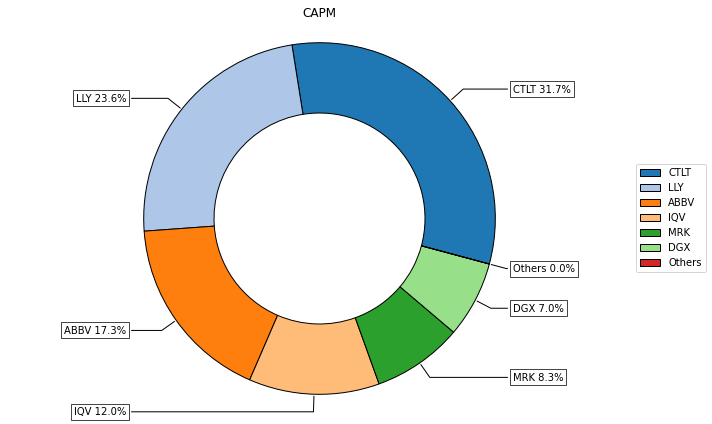

In [10]:
ax = plf.plot_pie(w=W2, title='CAPM', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


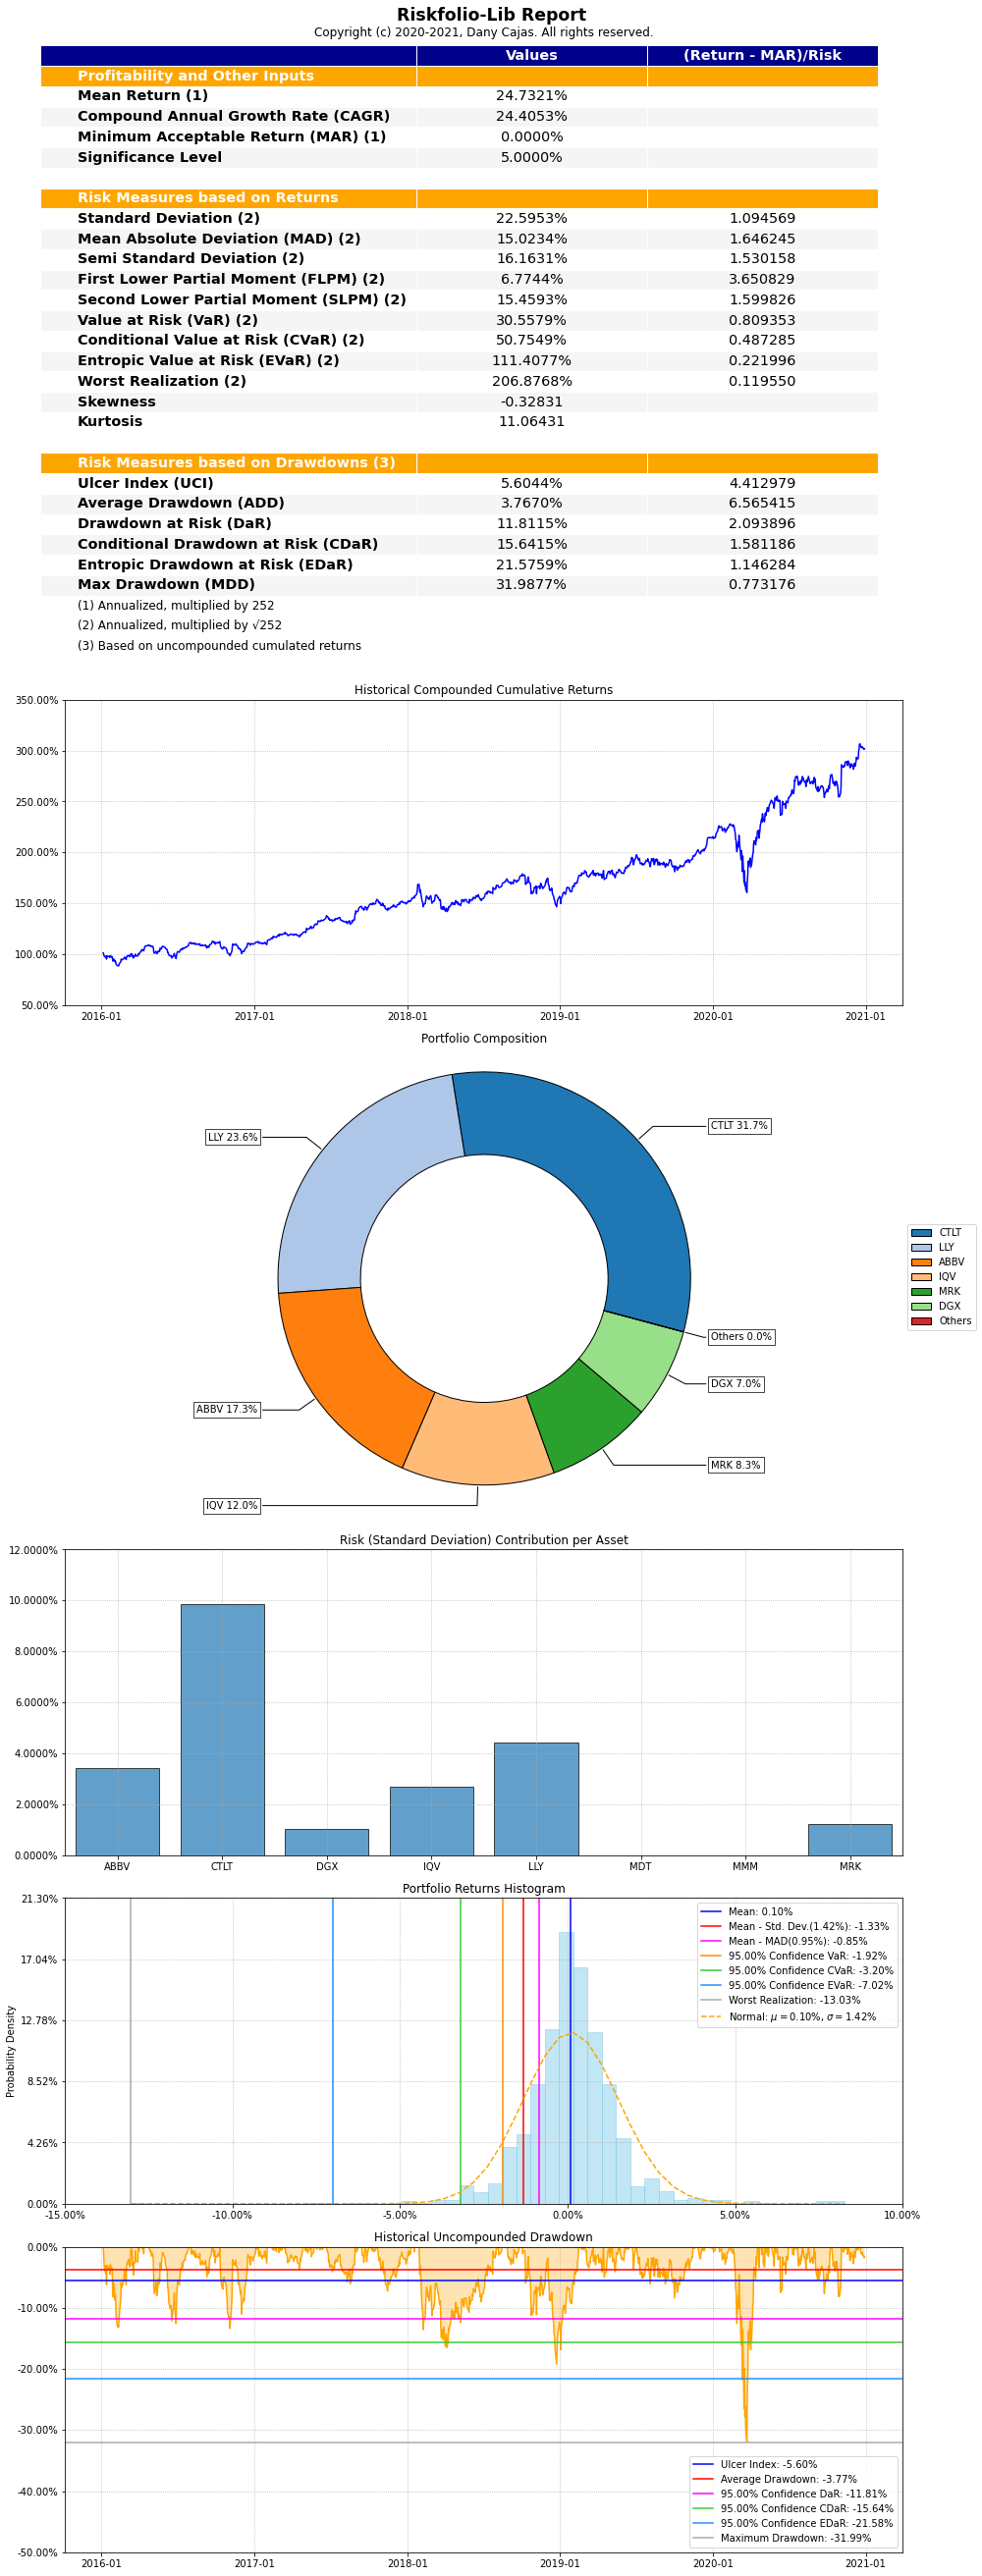

In [11]:
import riskfolio.Reports as rp

ax_report = rp.jupyter_report(port_diff, w=W2, rm='MV', rf=0, alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)

In [12]:
################################################## ###################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
############ ################################################## ###########

# Loading the information of the factors 
#dt.date
three_factor = pd.read_csv('FF_three.csv', index_col=0, header=0)/100
three_factor = three_factor.loc[start: end][:-2]
x = three_factor[['Mkt-RF', 'SMB', 'HML']].values
#display(three_factor)
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [13]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))

In [14]:
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2

In [15]:
w_fama_three = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\problems\problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [16]:
W3 = pd.DataFrame(w_fama_three, index = assets, columns = ['Fama Three'])

In [17]:
display(W3)

Fama Three
ABBV    0.116249
CTLT    0.129808
DGX     0.114804
IQV     0.176874
LLY     0.120605
MDT     0.128458
MMM     0.081618
MRK     0.131585

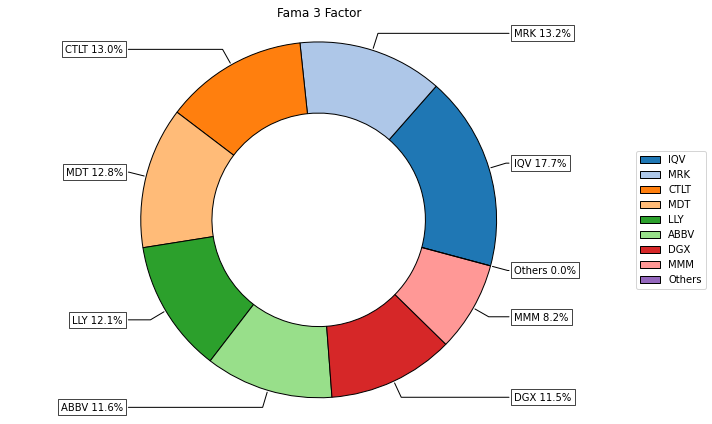

In [18]:
ax = plf.plot_pie(w=W3, title='Fama 3 Factor', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


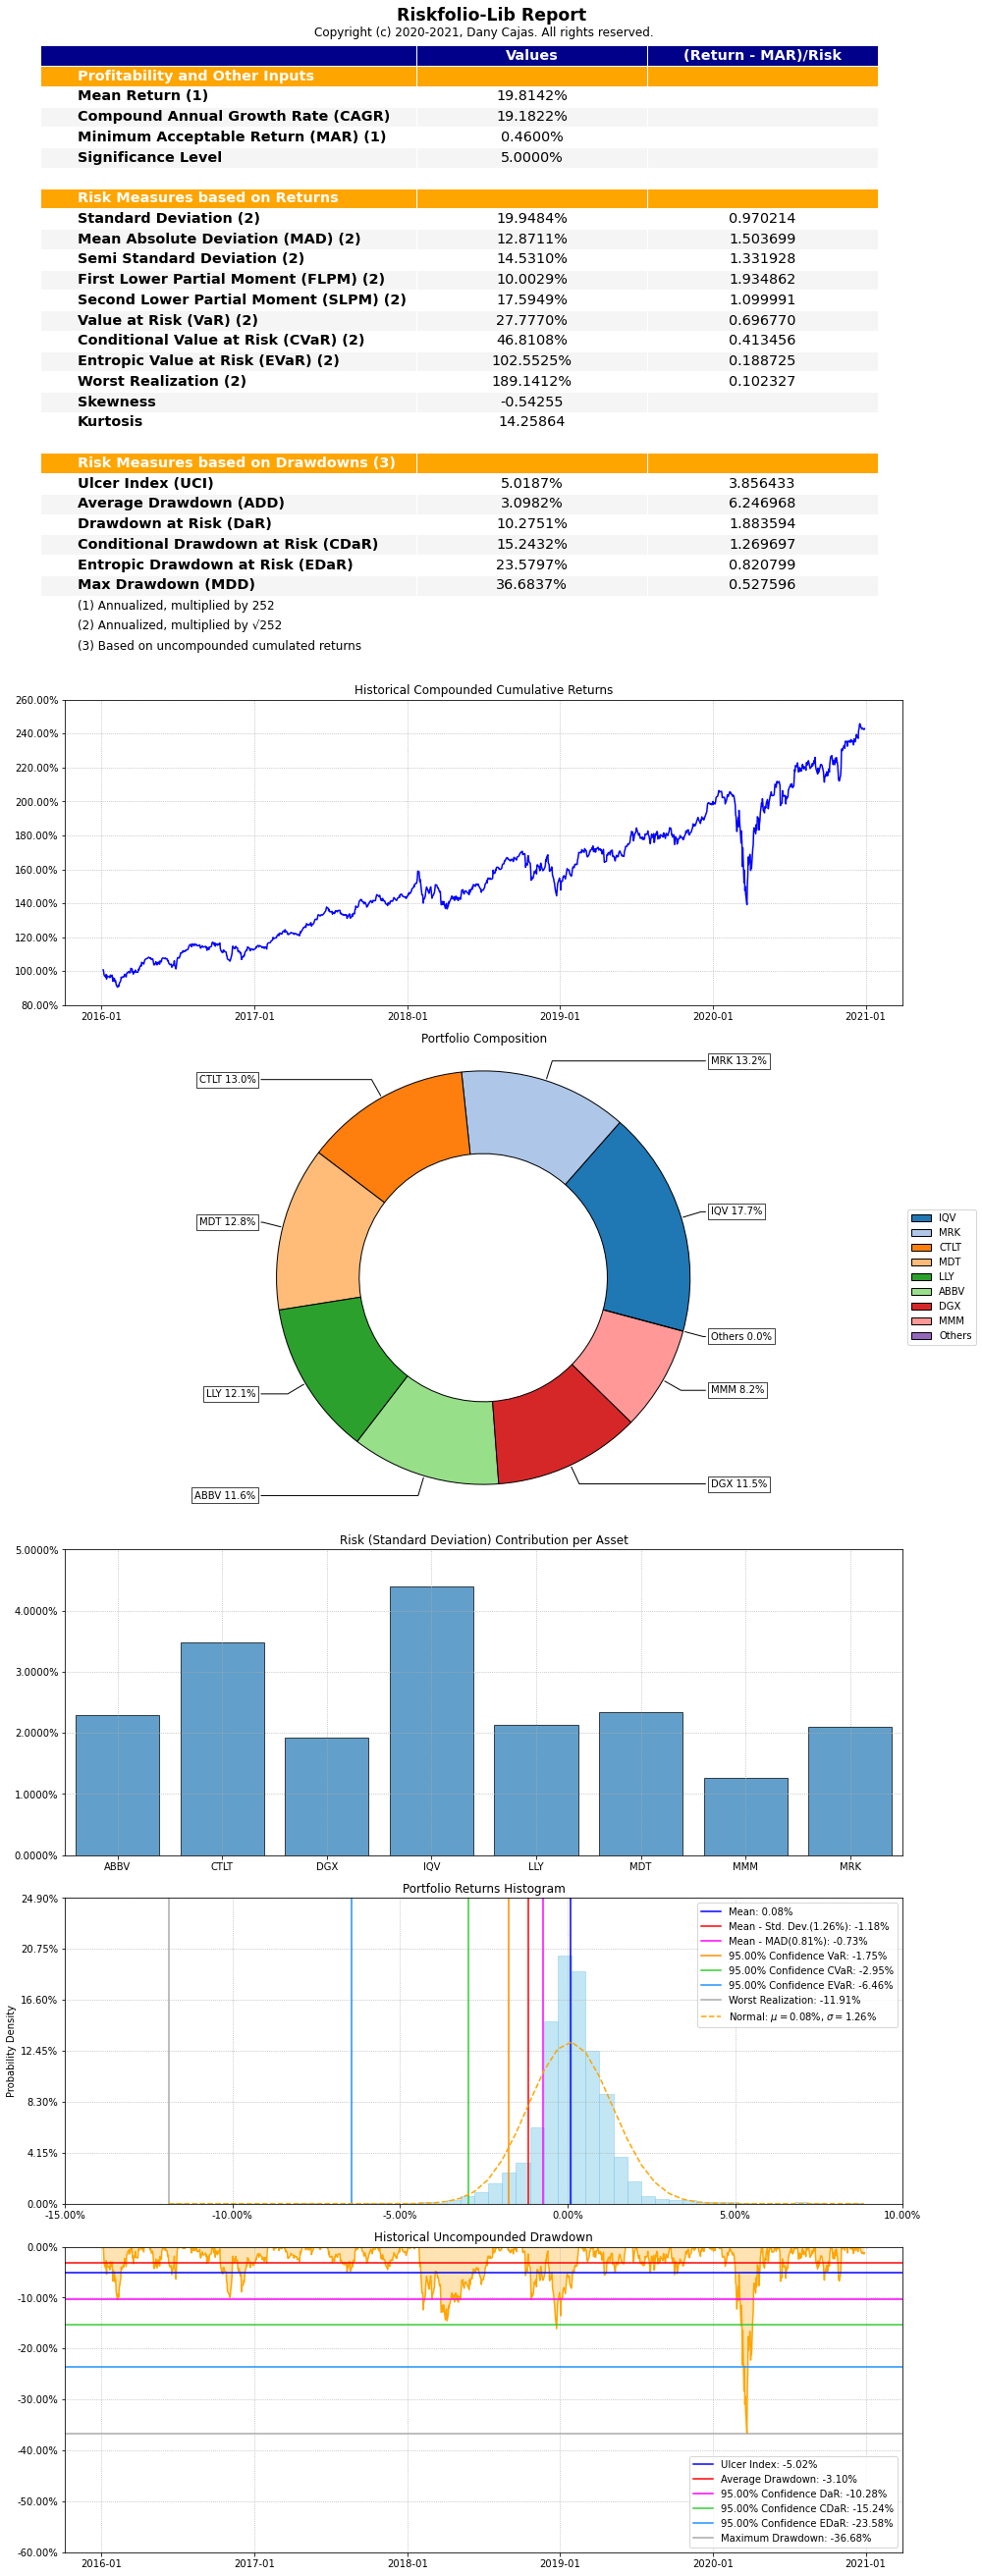

In [19]:
ax_report = rp.jupyter_report(port_diff, w=W3, rm='MV', rf=three_factor['Mkt-RF'][-1], alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)

In [20]:
five_factor = pd.read_csv('FF_five.csv', index_col=0, header=0)/100
five_factor = five_factor.loc[start: end][:-2]
x = five_factor[['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [21]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2
w_fama_five = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


In [22]:
W4 = pd.DataFrame(w_fama_five, index = assets, columns = ['Fama Five'])
#display(W4)

Fama Five
ABBV   0.117309
CTLT   0.128222
DGX    0.113459
IQV    0.172728
LLY    0.124789
MDT    0.126619
MMM    0.078478
MRK    0.138395

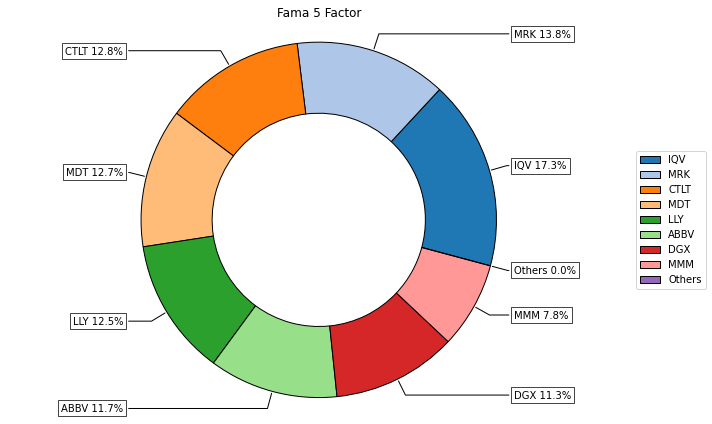

In [23]:
ax = plf.plot_pie(w=W4, title='Fama 5 Factor', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


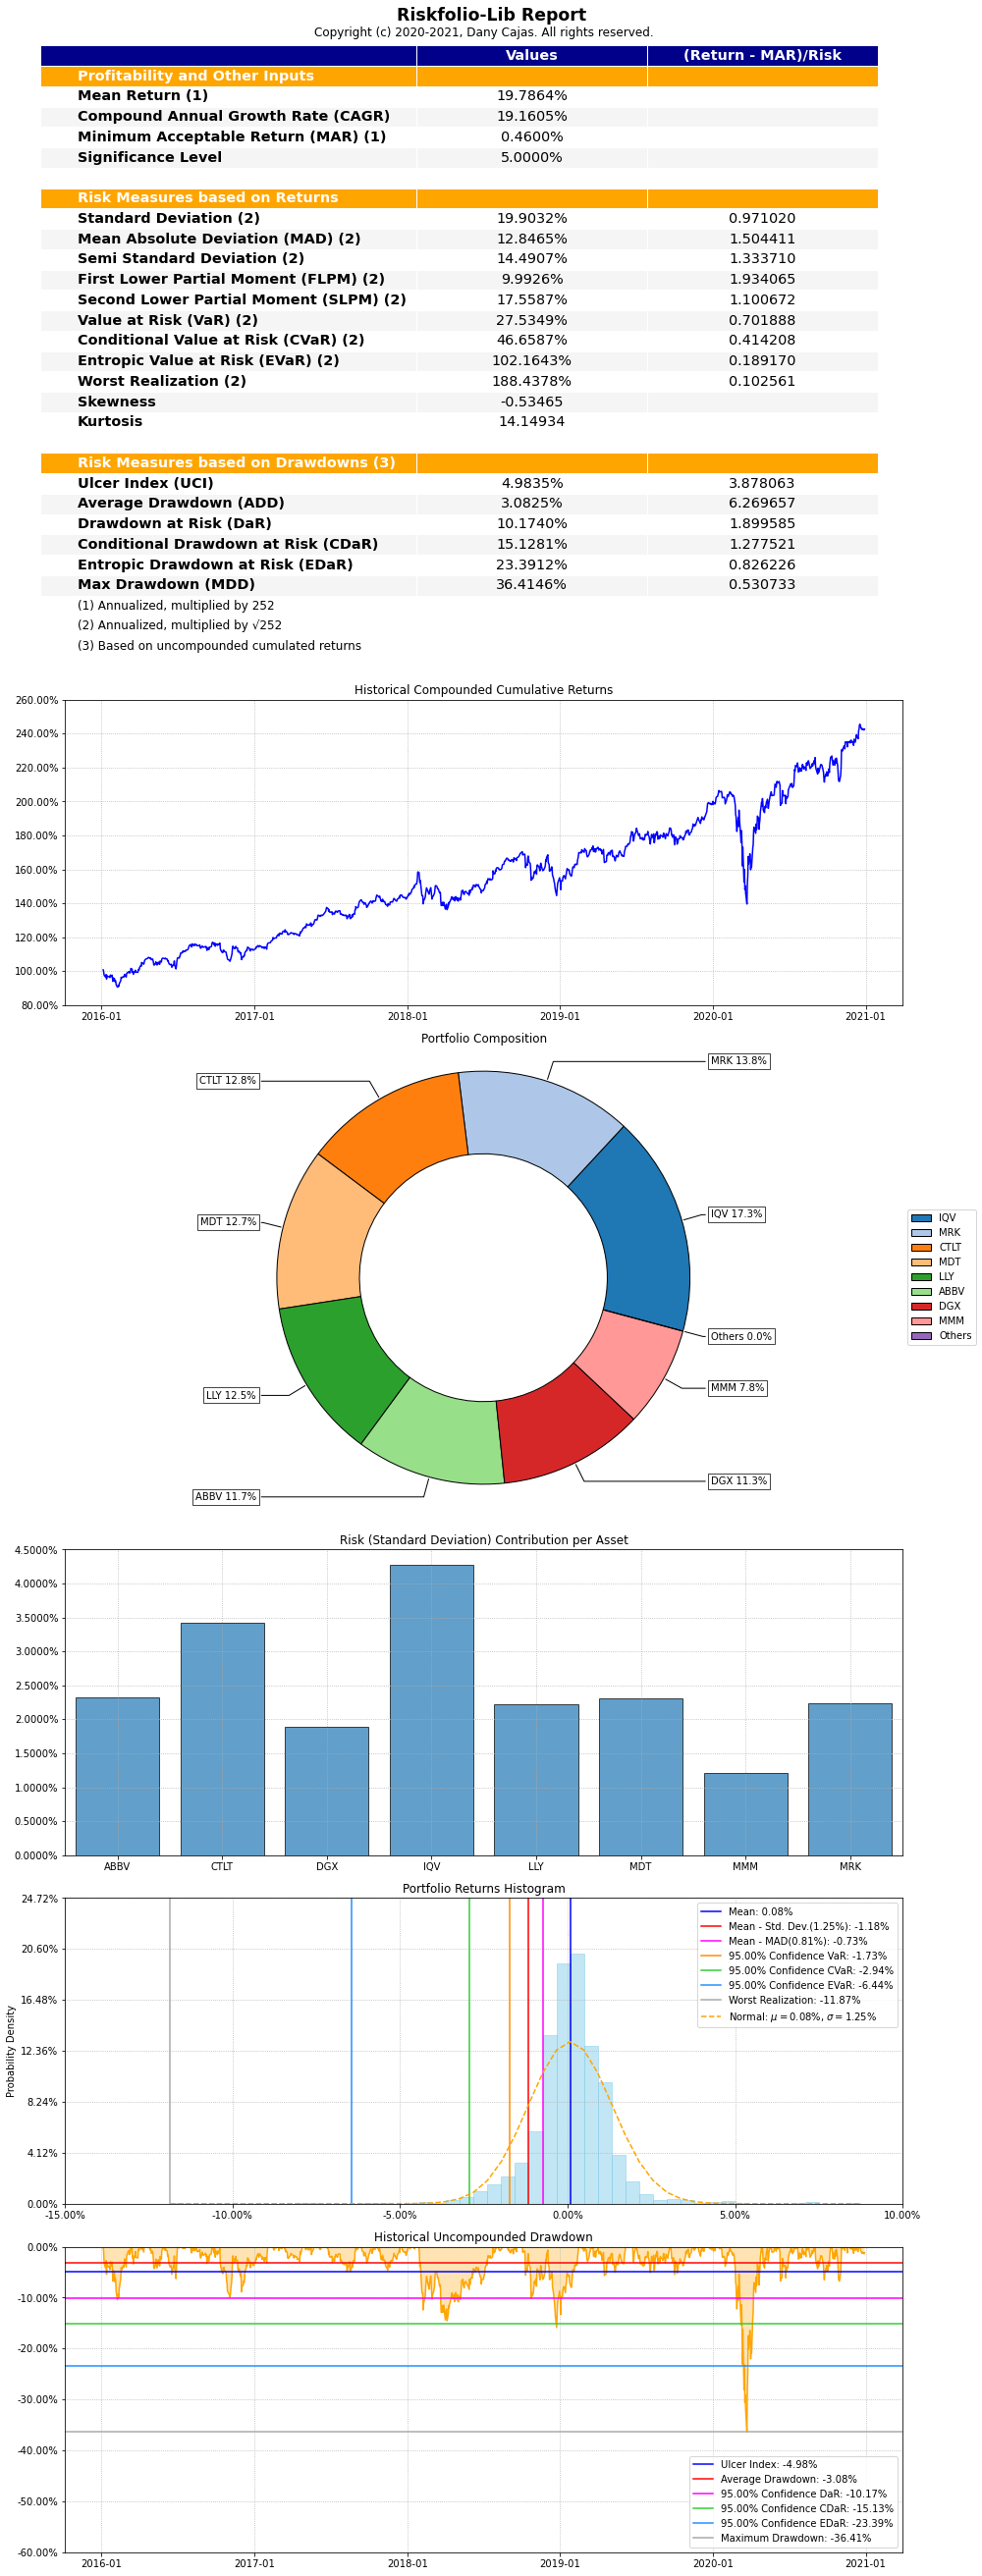

In [24]:
ax_report = rp.jupyter_report(port_diff, w=W4, rm='MV', rf=five_factor['Mkt-RF'][-1], alpha=0.05, height=6, width=14,others=0.05, nrow=25)
